# Variable flip angle technique

In [4]:
# import statements
import os
import numpy
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman 

## Background
Variable flip angle (VFA) technique is a rapid T1 mapping technique based on the acquisition of several spoiled-gradient echo sequences with different flip angles (to do: add refs here). 
The minumum number of flip angle acquisitions is two.
VFA is often used to estimate T1 values in clinically reasonable scan times. However, it is known not to be very accurate and precise (to do: add refs here).

The following equation holds when a spoiled-gradient echo sequence is being used:
$$
    S(\theta) = \rho_0 \cdot \frac{\mathrm{sin}(\theta)(1-E_1)}{1-\mathrm{cos}(\theta) \cdot E_1}        
$$

with

$$
    E_1 = e^{\frac{-\mathrm{TR}}{T_1}}
$$
and $S(\theta)$ being the signal intensity at a certain flip angle $\theta$,  $\rho_0$ the spin density including system gain contributions, and TR the repetition time.

For fast calculation of T1 the problem is often linearized. If $\frac{S(\theta)}{sin(\theta)}$ is a linear function of $\frac{S(\theta)}{tan(\theta)}$, $E_1$, the slope of the line, can be calculated using linear regression.  This is what is done typically in the linear fit implementations.

$$
    \frac{S(\theta)}{sin(\theta)} = S_0(1-E_1) + E_1 \cdot \frac{S(\theta)}{tan(\theta)}
$$ 


## Description of test data
For the testing of the variable flip angle methods we used three data sets. For all three types of test data the same tolerances were used: absolute tolerance of 0.05 + relative tolerance of 0.05

#### Digital reference object (DRO) provided by the quantitative imaging biomarker alliance (QIBA). 
The original DRO consists of multiple groups of 10x10 voxels, each with a different combination of of noise level, S0 and R1. 
One voxel is selected per combination and  voxels with S0/sigma < 1500 are excluded. 

Details: QIBA T1 DRO v3
Citation: Daniel Barboriak, https://qidw.rsna.org/#collection/594810551cac0a4ec8ffe574

#### In-vivo data from a brain patient
Each entry corresponds to a voxel following spatial realignment of variable flip angle SPGR images, taken from ROIs drawn in the white matter, deep gray matter and cerebrospinal fluid.
R1 reference values obtained using in-house Matlab code (https://github.com/mjt320/HIFI). These values values are not B1-corrected here, thus may not reflect true R1.

Citation: Clancy, U., et al., "Rationale and design of a longitudinal study of cerebral small vessel diseases, clinical and imaging outcomes in patients presenting with mild ischaemic stroke: Mild Stroke Study 3." European Stroke Journal, 2020.

#### In-vivo data from patients with prostate cancer
Each entry corresponds to a randomly selected voxel in the prostate from variable flip angle SPGR images. Data from five prostate cancer patients were used.
T1 reference values obtained using in-house Matlab code. T1 values are provided with and without B1 correction and both with linear and nonlinear fitting procedures. 
Currently, we only test non-B1-corrected data and use reference values based on non-linear fitting.

Citation: Klawer et al., "Improved repeatability of dynamic contrast-enhanced MRI using the complex MRI signal to derive arterial input functions: a test-retest study in prostate cancer patients." Magn Reson Med, 2019.


## Import data

A JSON named `results-meta.json` is created to isolate the meta information. The following script can read this JSON and construct the corresponding data frame. The JSON contains a list of entries. Each entry contains the `path`, `filename`, `method` and `author`. To incorporate future results, one can just update this JSON file and re-run the following scripts.

In [11]:
! head -7 results-meta.json

[
  {
    "path": "../test/results/T1_mapping",
    "filename": "TestResults_T1mapping_mcgill_t1_VFA_lin.csv",
    "method": "linear",
    "author": "ZA_McGill_Can"
  },


In [12]:
import json
from pathlib import Path

In [18]:
# Load the meta data
meta = json.load(open("results-meta.json"))

In [20]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    fpath, fname, method, author = entry.values()
    df_entry = pd.read_csv(Path(fpath, fname)).assign(method=method, author=author)
    df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [25]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('brain'),'source'] = 'brain'
df.loc[df['label'].str.contains('prostaat'),'source'] = 'prostate'
df.loc[df['label'].str.contains('QIBA'),'source'] = 'DRO' 

# calculate error between measured and reference R_1 values
df['error_r1'] = df['r1_measured'] - df['r1_ref']

## DRO data

In [198]:
tolerances = { 'r1': {'atol' : 0.05, 'rtol': 0.05 }}
labelx='$\Delta$ $R_{1}$ (s$^{-1}$)'
labely='$\Delta$ $R_{1}$ (s$^{-1}$)'

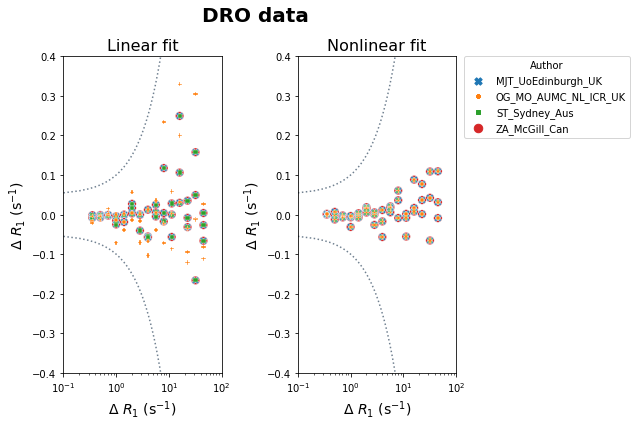

In [199]:
# first plot results of linear fit
data_linear = df[(df['source']=='DRO') & (df['method']=='linear')]    
fig, ax = plt.subplots(1,2, sharey='none', figsize=(9,6))
plot_bland_altman(ax[0], data_linear, tolerances, 'r1', log_plot=True, xlim=[10**-1,10**2], ylim=(-0.4,0.4),
                  label_xaxis=labelx, label_yaxis=labely, fig_title='Linear fit')

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)

# plot results of nonlinear fit
data_nonlinear = df[(df['source']=='DRO') & (df['method']=='nonlinear')] 
plot_bland_altman(ax[1], data_nonlinear, tolerances, 'r1', log_plot=True, xlim=[10**-1,10**2], ylim=(-0.4,0.4),
                  label_xaxis=labelx, label_yaxis=labely, fig_title='Nonlinear fit')

# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='Author', loc='upper left', borderaxespad=0)

# Here the position of the title should be adjusted
#  if the legend is moved to the side
fig.suptitle('DRO data',fontsize=20, fontweight='bold', x=0.4)
plt.tight_layout()
plt.show()

In [202]:
# Define a function to wrap up the plot
def plotPair(data_linear, data_nonlinear, xlim, ylim, suptitle,
             tolerances={'r1':{'atol':0.05, 'rtol':0.05}}, 
             tag='r1',
             log_plot=True,
             labelx='$\Delta$ $R_{1}$ (s$^{-1}$)',
             labely='$\Delta$ $R_{1}$ (s$^{-1}$)',
             suptitle_x=0.4):
    fig, ax = plt.subplots(1,2, sharey='none', figsize=(9,6))
    plot_bland_altman(ax[0], data_linear, tolerances, tag, log_plot=log_plot, xlim=xlim, ylim=ylim,
                      label_xaxis=labelx, label_yaxis=labely, fig_title='Linear fit')

    # Hide the legend for the left subplot
    ax[0].get_legend().set_visible(False)

    # plot results of nonlinear fit
    plot_bland_altman(ax[1], data_nonlinear, tolerances, 'r1', log_plot=True, xlim=xlim, ylim=ylim,
                      label_xaxis=labelx, label_yaxis=labely, fig_title='Nonlinear fit')

    # Set the position of the legend
    plt.legend(bbox_to_anchor=(1.05, 1), title='Author', loc='upper left', borderaxespad=0)

    # Here the position of the title should be adjusted
    #  if the legend is moved to the side
    fig.suptitle(suptitle,fontsize=20, fontweight='bold', x=suptitle_x)
    plt.tight_layout()

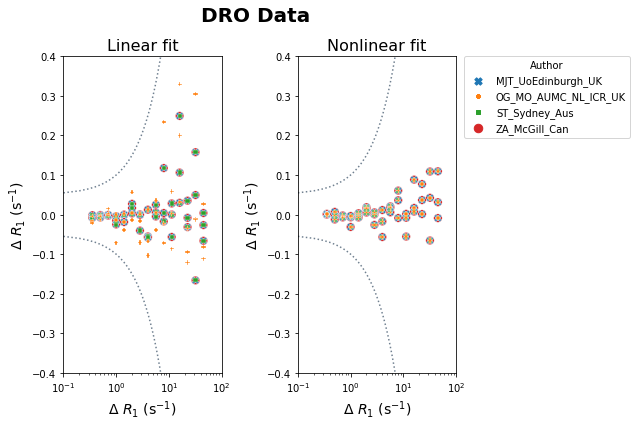

In [203]:
# Test the function, redo the DRO Data
plotPair(
    data_linear=df[(df['source']=='DRO') & (df['method']=='linear')],
    data_nonlinear=df[(df['source']=='DRO') & (df['method']=='nonlinear')],
    xlim=[10**-1,10**2],
    ylim=[-0.4, 0.4],
    suptitle='DRO Data'
)

In-vivo data

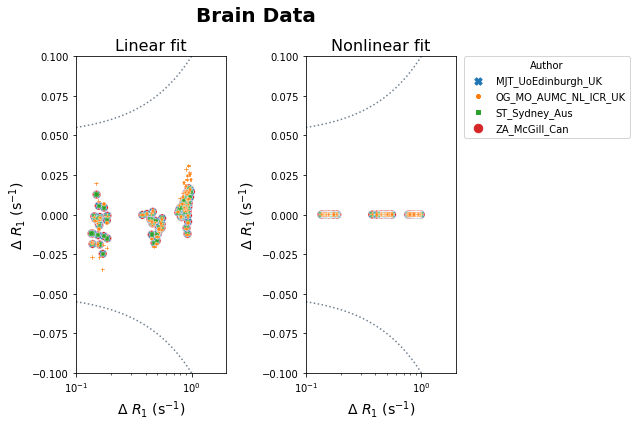

In [207]:
# In-vivo brain data
# Adjust the xlim, ylim if necessary
plotPair(
    data_linear=df[(df['source']=='brain') & (df['method']=='linear')],
    data_nonlinear=df[(df['source']=='brain') & (df['method']=='nonlinear')],
    xlim=[10**-1,10**0.3],
    ylim=[-0.1, 0.1],
    suptitle='Brain Data'
)

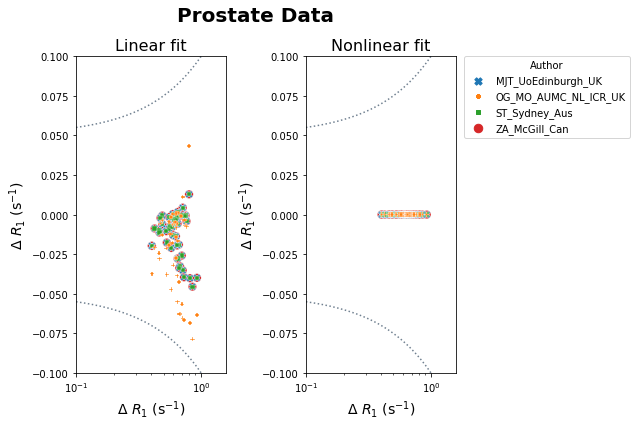

In [210]:
# In-vivo prostate data
# Adjust the xlim, ylim if necessary
plotPair(
    data_linear=df[(df['source']=='prostate') & (df['method']=='linear')],
    data_nonlinear=df[(df['source']=='prostate') & (df['method']=='nonlinear')],
    xlim=[10**-1,10**0.2],
    ylim=[-0.1, 0.1],
    suptitle='Prostate Data'
)

# Previous cells
This is the *original* code to plot the brain and prostate data. It's kept for any future reference.

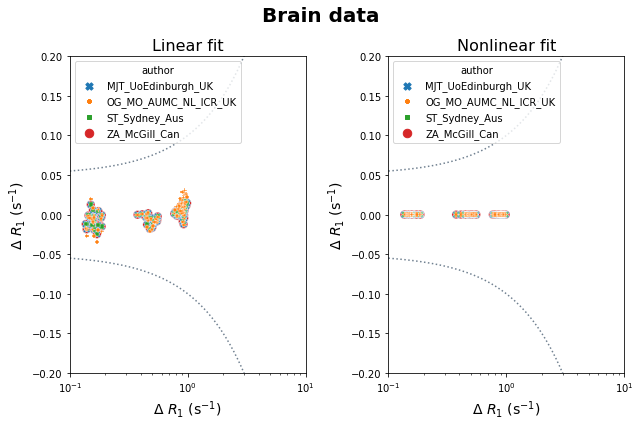

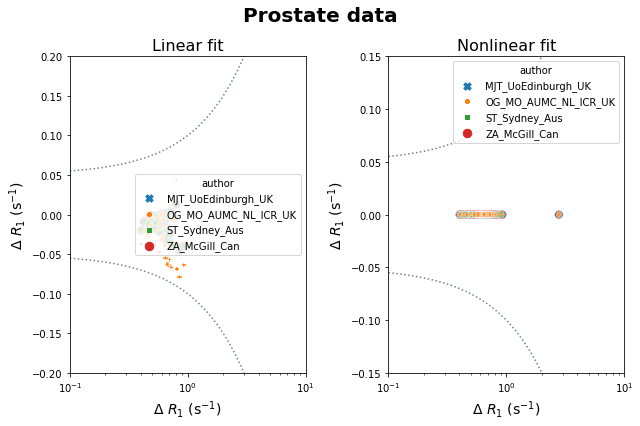

In [211]:
## in-vivo brain data
# first plot results of linear fit
data_linear = df[(df['source']=='brain') & (df['method']=='linear')]    
fig, ax = plt.subplots(1,2, sharey='none', figsize=(9,6))
plot_bland_altman(ax[0], data_linear, tolerances, 'r1',log_plot=True, xlim=[10**-1,10**1],ylim=(-0.2,0.2),label_xaxis='$\Delta$ $R_{1}$ (s$^{-1}$)',label_yaxis='$\Delta$ $R_{1}$ (s$^{-1}$)', fig_title='Linear fit')
# plot results of nonlinear fit
data_nonlinear = df[(df['source']=='brain') & (df['method']=='nonlinear')] 
plot_bland_altman(ax[1], data_nonlinear, tolerances, 'r1',log_plot=True, xlim=[10**-1,10**1],ylim=(-0.2,0.2),label_xaxis='$\Delta$ $R_{1}$ (s$^{-1}$)',label_yaxis='$\Delta$ $R_{1}$ (s$^{-1}$)', fig_title='Nonlinear fit')
fig.suptitle('Brain data',fontsize=20, fontweight='bold')
plt.tight_layout()

## in-vivo prostate data
# first plot results of linear fit
data_linear = df[(df['source']=='prostate') & (df['method']=='linear')]    
fig, ax = plt.subplots(1,2, sharey='none', figsize=(9,6))
plot_bland_altman(ax[0], data_linear,tolerances, 'r1',log_plot=True, xlim=[10**-1,10**1],ylim=(-0.2,0.2),label_xaxis='$\Delta$ $R_{1}$ (s$^{-1}$)',label_yaxis='$\Delta$ $R_{1}$ (s$^{-1}$)', fig_title='Linear fit')
# plot results of nonlinear fit
data_nonlinear = df[(df['source']=='prostate') & (df['method']=='nonlinear')] 
plot_bland_altman(ax[1], data_nonlinear, tolerances,'r1',log_plot=True, xlim=[10**-1,10**1],ylim=(-0.15,0.15),label_xaxis='$\Delta$ $R_{1}$ (s$^{-1}$)',label_yaxis='$\Delta$ $R_{1}$ (s$^{-1}$)', fig_title='Nonlinear fit')
fig.suptitle('Prostate data',fontsize=20, fontweight='bold')
plt.tight_layout()

## Notes
Additional notes/remarks

### References